# Figures: Fellner 2019 - Formal Comments
This notebook will reproduce all figures from the PLOS Biology Update Article

### Imports

In [1]:
# imports
from os.path import join
from os import listdir

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from scipy import stats

# import pyvista as pv

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from matplotlib.transforms import Bbox

from mne import read_epochs
import statsmodels.api as sm

In [2]:
# import Voytek lab tools
from specparam import SpectralGroupModel
from specparam.bands import Bands
from specparam.analysis import get_band_peak
from specparam.sim import sim_power_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

In [3]:
import sys
sys.path.append('C:/users/micha/tilt_vs_fingerprint/code/plotting')
from plot_ieeg_2_tfr import crop_tfr, downsample_tfr

sys.path.append('C:/users/micha/tilt_vs_fingerprint/code/pipeline_ieeg')
from ieeg_6_prep_ols_data import gen_df_alpha, gen_df_exp

### Parameters

In [4]:
# project params

# paths and filenames
PROJECT_PATH = 'C:/Users/micha/tilt_vs_fingerprint/'
DIR_FIG = join(PROJECT_PATH, 'figures/manuscript_figures')
DIR_STATS = join(PROJECT_PATH, 'data/ieeg_stats/permutation_test')
FNAME_STATS = join(PROJECT_PATH, 'data/fellner_stats/fellner_stats_df.pkl')

# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22'] # subject IDs


In [5]:
# spectral analysis parameters

# define spectral bands of interest
bands = Bands({'alpha' : [8, 20]})

# define aperiodic mode
AP_MODE = 'knee'

# specparam hyperparameters
PEAK_WIDTH_LIMITS = [2, 20] # default: (0.5, 12.0))
MAX_N_PEAKS = 4 # (default: inf)
MIN_PEAK_HEIGHT = 0 # (default: 0)
PEAK_THRESHOLD =  2 # (default: 2)
AP_MODE = 'knee'

In [6]:
# plotting parameters

# set RC Params
plt.figure()
plt.style.use(join('C:/users/micha/.matplotlib/stylelib', 'fellner_response.mplstyle'))

# set color palette
COLS_1 = np.array([1,133,113]) /255
COLS_1b = np.array([128,205,193]) /255

COLS_0 = np.array([166,97,26]) /255
COLS_0b = np.array([223,194,125]) /255

# size of subplot labels for figures
FONTSIZE_SUBPLOTS = 12

# pad top of figure to make room for subplot labels
LABEL_PAD = 0.2

<Figure size 432x288 with 0 Axes>

In [7]:
# significant level for permutation testing
SIG_LEVEL = 0.01

In [8]:
# indicate whether to save figures
SAVE_FIG = True

### Load data

In [9]:
# load channel info
chan_info = np.load(join(PROJECT_PATH, 'data/ieeg_metadata', 'ieeg_channel_info.pkl'), allow_pickle=True)
chan_info.head()

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,0,pat02,0,A01-A02,-65.431,61.9449,3.55955
1,1,pat02,1,A02-A03,-70.93895,57.17765,12.1554
2,2,pat02,2,A03-A04,-75.3955,51.3944,20.94335
3,3,pat02,3,A04-A05,-78.9195,43.9098,30.13485
4,4,pat02,4,A05-A06,-80.96735,35.21485,38.13475


In [10]:
# load spectral parameterization results

# initialize dataframe to aggregate spec param results
temp = pd.DataFrame(columns=['time_window','material','r_squared','exponent','alpha'])
params = pd.concat([chan_info, temp], sort=False)
params = pd.concat([params,params,params,params])

# initialize arrays to collect data across files
material, window, r2, exp, alpha = [], [], [], [], []

# load results for each condition and add to dataframe
for mat in ['word', 'face']:
    for win in ['pre', 'post']:
        # aggragate info on trial condition
        window.append([win] * len(chan_info))
        material.append([mat] * len(chan_info))
        
        # load spec param results
        sp = SpectralGroupModel()
        fname_in = 'psd_%s_%s_params_%s.json' %(win, mat, AP_MODE)
        sp.load(join(PROJECT_PATH, 'data/ieeg_psd_param', fname_in))
        
        # aggregate data of interest
        r2.append(sp.get_params('r_squared'))
        exp.append(sp.get_params('aperiodic','exponent'))
        alpha_params = get_band_peak(sp, bands.alpha)
        alpha.append(alpha_params[:,1])

# add aggregate data to dataframe
params['time_window'] = np.ravel(window)
params['material'] = np.ravel(material)
params['r_squared'] = np.ravel(r2)
params['exponent'] = np.ravel(exp)
params['alpha'] = np.ravel(alpha)

print(params.shape)
params.head()

C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


(2780, 12)


,index,patient,chan_idx,label,pos_y,pos_x,pos_z,time_window,material,r_squared,exponent,alpha
0,0.0,pat02,0,A01-A02,-65.431,61.9449,3.55955,pre,word,0.993555,3.542673,0.213201
1,1.0,pat02,1,A02-A03,-70.93895,57.17765,12.1554,pre,word,0.994284,3.052480,0.210785
2,2.0,pat02,2,A03-A04,-75.3955,51.3944,20.94335,pre,word,0.994435,2.774045,0.276397
3,3.0,pat02,3,A04-A05,-78.9195,43.9098,30.13485,pre,word,0.993285,2.940543,NaN
4,4.0,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pre,word,0.993028,2.872949,0.227912


In [11]:
# Reduce dataframe to channels with reported effects

# load published results (Fellner, 2019) 
df_stats = np.load(FNAME_STATS, allow_pickle=True)

# identify channels with reported effects
sig_chans = df_stats['h_cond_alphabeta'] | df_stats['h_cond_gamma']

# reduce dataframe to significant channels
mask_sig_chans = np.concatenate([sig_chans,sig_chans,sig_chans,sig_chans])
params_sig = params[mask_sig_chans]
# params_sig.reset_index(inplace=True)
params_sig


,index,patient,chan_idx,label,pos_y,pos_x,pos_z,time_window,material,r_squared,exponent,alpha
1,1.0,pat02,1,A02-A03,-70.93895,57.17765,12.1554,pre,word,0.994284,3.052480,0.210785
2,2.0,pat02,2,A03-A04,-75.3955,51.3944,20.94335,pre,word,0.994435,2.774045,0.276397
8,8.0,pat02,8,C03-C04,-74.67955,3.14125,33.31045,pre,word,0.992242,2.794818,0.234429
9,0.0,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,pre,word,0.991604,3.189699,0.655227
38,29.0,pat04,29,A48-A56,5.42945,57.1763,38.78825,pre,word,0.984261,3.326450,0.283847
...,...,...,...,...,...,...,...,...,...,...,...,...
682,40.0,pat22,40,LOF_02-LOF_03,32.0,-29.0,-15.5,post,face,0.991279,2.706833,NaN
683,41.0,pat22,41,LOF_03-LOF_04,34.5,-28.0,-8.5,post,face,0.991874,2.592466,0.154132
692,50.0,pat22,50,MOF_07-MOF_08,44.5,-14.0,16.5,post,face,0.991042,3.271724,0.357387
693,51.0,pat22,51,MOF_08-MOF_09,48.0,-14.0,23.5,post,face,0.990115,2.708726,0.240655


In [12]:
# load rotation analysis results
data_in_word = np.load(join(PROJECT_PATH,'data/ieeg_intersection_results/simulation_approach', 
                             'intersection_results_%s_%s.npz' %('word', AP_MODE)), allow_pickle=True)
data_in_face = np.load(join(PROJECT_PATH,'data/ieeg_intersection_results/simulation_approach', 
                             'intersection_results_%s_%s.npz' %('face', AP_MODE)), allow_pickle=True)
f_rot_word = data_in_word['intersection']
f_rot_face = data_in_face['intersection']


## Figure 1. Spectral signatures of memory encoding.
Models  
> A. Oscillations  
> B. Aperiodic shift  
> C. Combined

In [13]:

def plot_model_sketch(ax, spectrum_pre, spectrum_post, freqs, title, plt_legend=False):

    """
    plot model for stimulus-evoked spectral modulation.
    
    
    Parameters
    ----------
    ax : matplotlib axes
        axes on which to plot.
    spectrum_pre : 1d array
        power spectrum for baseline epoch.
    spectrum_post : 1d array
        power spectrum for encoding epoch.
    freqs : 1d array
        frequency vector for spectra.
    title : str
        plot title.

    """
    
    # plot
    ax.loglog(freqs, spectrum_pre, label='baseline', color='grey')
    ax.loglog(freqs, spectrum_post, label='encoding', color='k')
    
    # label
    ax.set_title(title)
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('power (\u03BCV\u00b2/Hz)')
    ax.legend()
    ax.set_xticks([1,10,100])
    ax.set_xticklabels(['1','10','100'])
    
    # annotations
    ax.axvspan(8, 20, facecolor='grey', alpha=0.2)
    ax.axvspan(50, 90, facecolor='grey', alpha=0.2)
    ax.set_xlim([1,200])
#     ax.text(0.37, 0.925, 'Alpha/beta', fontsize=10, transform=ax.transAxes)
#     ax.text(0.82, 0.925, 'Gamma', fontsize=10, transform=ax.transAxes)
        

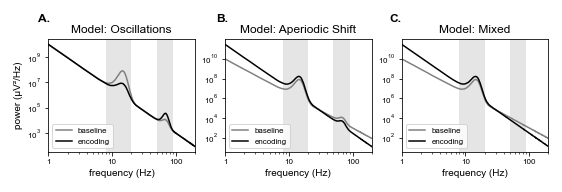

In [14]:
# plot models

# settings
freq_range = [1,200]
params_ap = [10, 3.5]
f_rot = 30
delta_exp = 1

# create figure
figsize_x = 7.5
figsize_y = 2.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[figsize_x, figsize_y])

# simulate oscillations model
freqs, spectrum_pre = sim_power_spectrum(freq_range, params_ap, [[15,2,3],[70,0.5,8]])
_, spectrum_post = sim_power_spectrum(freq_range, params_ap, [[15,1,3],[70,1,8]])
plot_model_sketch(ax1, spectrum_pre, spectrum_post, freqs, 'Model: Oscillations', plt_legend=True)

# simulate oscillations model
freqs, spectrum_pre = sim_power_spectrum(freq_range, params_ap, [[15,2,3],[70,0.5,8]])
spectrum_post = rotate_powerlaw(freqs, spectrum_pre, delta_exponent=delta_exp, f_rotation=f_rot)
plot_model_sketch(ax2, spectrum_pre, spectrum_post, freqs, 'Model: Aperiodic Shift')

# simulate mixed model
freqs, spectrum_pre = sim_power_spectrum(freq_range, params_ap, [15,2,3])
_, spectrum_post = sim_power_spectrum(freq_range, params_ap, [15,2,3])
spectrum_post = rotate_powerlaw(freqs, spectrum_post, delta_exponent=delta_exp, f_rotation=f_rot)
plot_model_sketch(ax3, spectrum_pre, spectrum_post, freqs, 'Model: Mixed')

# adjust figure appearance
ax2.set_ylabel('')
ax3.set_ylabel('')

# add subplot labels
fig.text(0.05, 1, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.38, 1, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.7, 1, 'C.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# save figure
if SAVE_FIG:
    fig.savefig(join(DIR_FIG, 'fig1'),
               bbox_inches=Bbox([[0, 0],[figsize_x, figsize_y+LABEL_PAD]]))

## Figure 2. Single-electrode responses to visual stimulation.
> A. iEEG time-series (5 single-trial examples)  
> B. Single-channel power spectra: baseline v encoding with intersection labelled

In [13]:
# Choose an example pateint and channel 

# example visual cortex channels: Patient 11, channel 33-37
PATIENT = 'pat11'
CHAN_IDX = 34
MATERIAL = 'word'

# Figure settings
WIDTH_FIG2 = 7.5
HEIGHT_FIG2 = 2.2

In [16]:
# load data for example channel

# load iEEG time-series results
fname_in = '%s_%ss_hit_epo.fif' %(PATIENT, MATERIAL)
epochs = read_epochs(join(PROJECT_PATH,'data/ieeg_epochs', fname_in))
signals = epochs.get_data()
signal = signals[:, CHAN_IDX]
time = epochs.times

# load spectral results
fname_in = '%s_%ss_hit_XXXstim_psd.npz' %(PATIENT, MATERIAL)
psd_pre_in = np.load(join(PROJECT_PATH,'data/ieeg_psd', fname_in.replace('XXX','pre')))
psd_post_in = np.load(join(PROJECT_PATH,'data/ieeg_psd', fname_in.replace('XXX','post')))
psd_pre_all = psd_pre_in['psd'][:,CHAN_IDX]
psd_post_all = psd_post_in['psd'][:,CHAN_IDX]
freq = psd_pre_in['freq']

# calc confidence interval for spectra (across trials)
conf_pre = stats.norm.interval(0.95, loc=np.mean(psd_pre_all, 0),
                               scale=np.std(psd_pre_all, 0)/np.sqrt(len(psd_pre_all)))
conf_post = stats.norm.interval(0.95, loc=np.mean(psd_post_all, 0),
                               scale=np.std(psd_post_all, 0)/np.sqrt(len(psd_post_all)))

# get rotation frequency and index
f_rotation = f_rot_word[(chan_info['patient']==PATIENT) & (chan_info['chan_idx']==CHAN_IDX)]
idx_rotation = np.argmin(np.abs(freq - f_rotation))


Reading C:\Users\micha\tilt_vs_fingerprint\data\ieeg_epochs\pat11_words_hit_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 5 columns
55 matching events found
No baseline correction applied
0 projection items activated


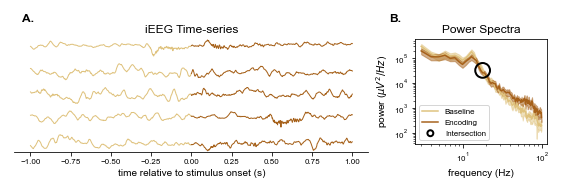

In [17]:
# plot fig 2

# create gridspec and nested gridspec for subplots
fig = plt.figure(figsize=[WIDTH_FIG2,HEIGHT_FIG2])
gs = gridspec.GridSpec(1,2, figure=fig, width_ratios=[2,1])
gs2a = gridspec.GridSpecFromSubplotSpec(5,1, subplot_spec=gs[0], hspace=0)
gs2b = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[1])

# ==================== Fig 2a ====================
# plot raw time-series (baseline and encoding)

# sererate baseline and encoding
mask_b = (time>=-1)&(time<=0)
mask_e = (time>=0)&(time<=1)

# create subplots
ax0 = fig.add_subplot(gs2a[0,:])
ax1 = fig.add_subplot(gs2a[1,:])
ax2 = fig.add_subplot(gs2a[2,:])
ax3 = fig.add_subplot(gs2a[3,:])
ax4 = fig.add_subplot(gs2a[4,:])
axes = [ax0,ax1,ax2,ax3,ax4]

# plot 5 trials
trials = np.random.randint(0, len(signal), 5)
# trials = np.array([31,  0,  9, 32, 46])
for trial, ax in zip(trials, axes):
# for ii in range(5):
    # plot
    ax.plot(time[mask_b], signal[trial, mask_b], color=COLS_0b, linewidth=1)
    ax.plot(time[mask_e], signal[trial, mask_e],  color=COLS_0, linewidth=1)

# remove cluttered axes, ticks, and spines
ax4.axes.yaxis.set_ticks([])
for ax in axes[:4]:
    ax.axis('off')
for loc in ['top','right','left']:
    ax4.spines[loc].set_visible(False)

# label
ax0.set_title('iEEG Time-series')
ax4.set_xlabel('time relative to stimulus onset (s)')

# label time windows
# fig.text(0.2, .85, 'Baseline',  fontsize=16)
# fig.text(0.7, .85, 'Encoding', fontsize=16)

# ==================== Fig 2b ====================
# create subplot
ax2b = fig.add_subplot(gs2b[0,0])

# Plot spectra
ax2b.loglog(freq, np.nanmean(psd_pre_all, 0), color=COLS_0b, label='Baseline')
ax2b.loglog(freq, np.nanmean(psd_post_all, 0), color=COLS_0, label='Encoding')

# plot 95% confidence intrval
ax2b.fill_between(freq, conf_pre[0], conf_pre[1], color=COLS_0b, alpha=0.5)
ax2b.fill_between(freq, conf_post[0], conf_post[1], color=COLS_0, alpha=0.5)

# plot intersection frequnency
ax2b.scatter(f_rotation, np.nanmean(psd_pre_all,0)[idx_rotation], s=218, facecolors='none', edgecolor='k',
            zorder=5, label='Intersection', marker='o', linewidth=2)

# subplot 2 - label
ax2b.set_title('Power Spectra') #('Single-electrode Spectra', fontsize=20)
ax2b.set_xlabel('frequency (Hz)')
ax2b.set_ylabel('power ($\u03bcV^2/Hz$)')
ax2b.legend(markerscale=0.4)

# ==================== save ====================

# add subplot labels
fig.text(0.02, 1, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.70, 1, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold');

# save figure
if SAVE_FIG:
    fig.savefig(join(DIR_FIG, 'fig2'),
               bbox_inches=Bbox([[0, 0],[WIDTH_FIG2, HEIGHT_FIG2+LABEL_PAD]]))

### Figure 2+ (not in manuscript)

In [1]:
# plot erp and variance

def plot_erp_and_var(signal, time, title, ylabel, fname_fig, mode='erp'):
    # create figure
    fig, ax = plt.subplots(figsize=[5,4], constrained_layout=True)

    # mode
    if mode=='erp':
        signal_plt = np.nanmean(signal, 0)
    elif mode=='var':
        signal_plt = np.nanstd(signal, 0)
    
    # plot erp/variance
    mask_b = (time>=-0.5)&(time<=0)
    mask_e = (time>=0)&(time<=1)
    ax.plot(time[mask_b], signal_plt[mask_b], 
             color=COLS_0b, linewidth=2, label='Baseline')
    ax.plot(time[mask_e], signal_plt[mask_e], 
             color=COLS_0, linewidth=2,  label='Encoding')

    # label
    ax.set_title(title)
    ax.set_xlabel('time (s)')
    ax.set_ylabel(ylabel)
    ax.legend()

    # plot confidence intervals for erp
    if mode=='erp':
        # calc confidence interval for spectra (across trials)
        conf_b = stats.norm.interval(0.95, loc=np.nanmean(signal[:,mask_b], 0),
                                       scale=np.nanstd(signal[:,mask_b], 0)/np.sqrt(len(signal[:,mask_b])))
        conf_e = stats.norm.interval(0.95, loc=np.nanmean(signal[:,mask_e], 0),
                                       scale=np.nanstd(signal[:,mask_e], 0)/np.sqrt(len(signal[:,mask_e])))

        # plot 95% confidence intrval
        ax.fill_between(time[mask_b], conf_b[0], conf_b[1], color=COLS_0b, alpha=0.5)
        ax.fill_between(time[mask_e], conf_e[0], conf_e[1], color=COLS_0, alpha=0.5)

    # save
#     if SAVE_FIG:
#         plt.savefig(join(DIR_FIG, fname_fig))


In [ ]:
# plot erp and variance
# load spectral results
fname_in = '%s_%ss_hit_epo.fif' %(PATIENT, MATERIAL)
epochs = read_epochs(join(PROJECT_PATH,'data/ieeg_epochs', fname_in))
signals = epochs.get_data()
signal = signals[:, CHAN_IDX]
time = epochs.times

plot_erp_and_var(signal, time, 'Event-related Potential', 'voltage (\u03bcV)', 'example_erp', 'erp')
plot_erp_and_var(signal, time, 'Across-trial Variance', 'variance ($\u03bcV^{2}$)', 'example_variance', 'var')


## Figure 3: The aperiodic exponent and alpha amplitude are modulated in a task-relevant manner.

> A. upper: Violin plot - Exponent  
> A. lower: Histogram - Exponent  
> B. upper: Violin plot - Alpha  
> B. lower: Histogram - Alpha  

### Figure 3a.
violin plots with supporting histograms/density plot - **exponent**

In [18]:
# Settings
WIDTH_FIG3 = 7
PAD_FIG3 = 0.05
HEIGHT_FIG3ab = 5

In [19]:
# define violin plot function
# contrast baseline v encoding seperately for face- and word-encoding blocks
# include plot below showing exp change with stimulus presentation

def plot_contrasts_violin(params, y_var, colors=['k','b'], y_label=None, fname_out=None, 
                          plot_swarm=True, loc='left', subplot_label=''):
    # set plotting params
    plotting_params = {
        'data':    params,
        'x':       'material',
        'hue':     'time_window',
        'y':       y_var,
        'split':   True
    }

    # create figure
    fig = plt.figure(figsize=(WIDTH_FIG3/2, HEIGHT_FIG3ab))
    gs = fig.add_gridspec(4,2)
    ax1 = fig.add_subplot(gs[:3,:])
    ax2l = fig.add_subplot(gs[3,0])
    ax2r = fig.add_subplot(gs[3,1])
    
    # ===== Upper Subplot =====
    # plot violin and swarm plots
#     pal = {"pre": COLS_1b, "post": COLS_1}
    pal = {"pre": colors[0], "post": colors[1]}
    vp = sns.violinplot(**plotting_params, ax=ax1, palette=pal)
    if plot_swarm:
        sp = sns.swarmplot(**plotting_params, color=[0,0,0], ax=ax1, size=2)

    # Label
    vp.set_title("%s" %y_label)
    vp.set_xlabel('')
    if y_label: vp.set_ylabel(y_label.lower())
    vp.set_xticklabels(['word block','face block'], fontsize=10)
    vp.xaxis.set_ticks_position('top')

    # remove mean and quartile line
    for l in ax1.lines:
        l.set_linewidth(0)

    # add legend (and add space)
    handles, _ = vp.get_legend_handles_labels()
    if loc == 'left':
        vp.legend(handles=handles, labels=['baseline','encoding'], bbox_to_anchor=(0.11, -0.5, 0.2, 0.5))
    elif loc == 'right':
        vp.legend(handles=handles, labels=['baseline','encoding'], bbox_to_anchor=(0.82, -0.5, 0.2, 0.5))
    
    # ===== Lower Subplot =====
    # plot disributions exponent change)
    diff_exp_word = params.loc[(params['time_window']=='post') & (params['material']=='word'), y_var] - \
                    params.loc[(params['time_window']=='pre') &  (params['material']=='word'), y_var]
    diff_exp_face = params.loc[(params['time_window']=='post') & (params['material']=='face'), y_var] - \
                    params.loc[(params['time_window']=='pre') &  (params['material']=='face'), y_var]
    
    # label
    max_val = np.nanmax(np.abs(np.concatenate([diff_exp_word,diff_exp_face])))
    for ax, diff_exp in zip([ax2l, ax2r], [diff_exp_word, diff_exp_face]):
        ax.hist(diff_exp, color='grey')
        ax.set(xlim=[-max_val, max_val])
        ax.set_xlabel('$\Delta$ %s \n(encoding - baseline)' %y_label.lower())
        ax.set_ylabel('channel count')
        ax.axvline(np.nanmean(diff_exp), color='k')

    # add subplot labels
    fig.text(0, 1.0, subplot_label, fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
    
    # save figure
    if fname_out: fig.savefig(join(DIR_FIG, fname_out),
                              bbox_inches=Bbox([[0, 0],[WIDTH_FIG3/2+PAD_FIG3, HEIGHT_FIG3ab+LABEL_PAD]]))
        
    return vp

C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


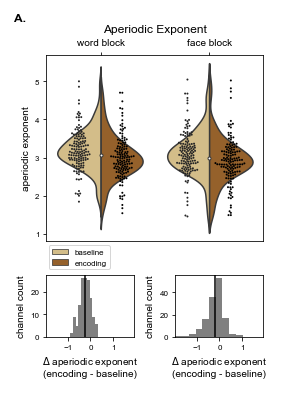

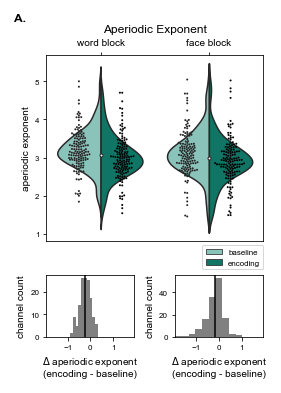

In [20]:
# execute plotting for exponent results

if SAVE_FIG:
    vp = plot_contrasts_violin(params_sig, 'exponent', y_label='Aperiodic Exponent', fname_out='figure_3_a_col0', 
                               colors=[COLS_0b, COLS_0], loc='left', subplot_label='A.')
    vp = plot_contrasts_violin(params_sig, 'exponent', y_label='Aperiodic Exponent', fname_out='figure_3_a_col1', 
                               colors=[COLS_1b, COLS_1], loc='right', subplot_label='A.')
else:
    vp = plot_contrasts_violin(params_sig, 'exponent', y_label='Aperiodic Exponent', 
                               colors=[COLS_0b, COLS_0], loc='left', subplot_label='A.')


### Figure 3b.
violin plots with supporting histograms/density plot - **alpha/beta**

C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Channels with alpha peak during both baseline and encoding: 87


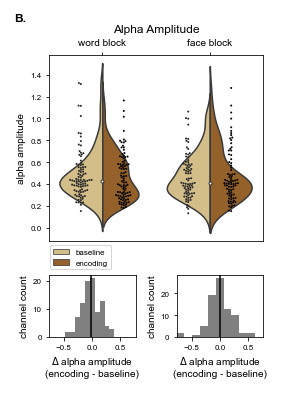

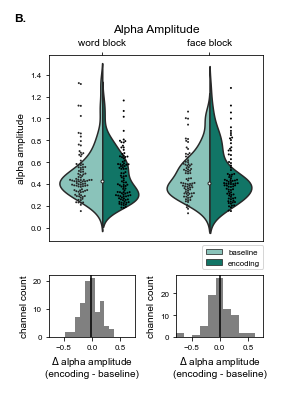

In [21]:
# execute plotting for alpha results

# remove channels with missing alpha peaks in either baseline or encoding
nan_mask = np.isnan(params_sig["alpha"])
params_apeak = params_sig[nan_mask]
params_apeak.reset_index(inplace=True)
a_peak = np.ones([len(params_sig)]).astype("bool")
for ii in range(len(params_apeak)):
    match = ((params_sig['patient']==params_apeak['patient'][ii]) & 
               (params_sig['chan_idx']==params_apeak['chan_idx'][ii]) &
               (params_sig['material']==params_apeak['material'][ii]))
    a_peak[match] = False
params_a_peak = params_sig[a_peak]

# plot
if SAVE_FIG:
    plot_contrasts_violin(params_a_peak, 'alpha', y_label='Alpha Amplitude', fname_out='figure_3_b_col0', 
                          colors=[COLS_0b, COLS_0], loc='left', subplot_label='B.')    
    plot_contrasts_violin(params_a_peak, 'alpha', y_label='Alpha Amplitude', fname_out='figure_3_b_col1', 
                          colors=[COLS_1b, COLS_1], loc='right', subplot_label='B.')    
else:
    plot_contrasts_violin(params_a_peak, 'alpha', y_label='Alpha Amplitude', 
                          colors=[COLS_0b, COLS_0], loc='left', subplot_label='B.')   

# print results
print('Channels with alpha peak during both baseline and encoding: %d' %(np.sum(a_peak)/4))

### Figure 3+ (not in manuscript)
brain maps

#### functions

In [ ]:
# plotting functions

def plot_brain_map(df_word, df_face, fname_fig=None, nan_vals=False, subplot_label=''):
    # plot brain mesh with electrodes colored based on statistical results
    
    # set camera postions for right hemispheres
    cpos_rh = [(522.8751422878058, -8.533968557192056, 2.1119098264702054),
               (0.21547583547528149, -18.471318770726832, 15.236837161591453),
               (0.023688404036230154, 0.07114592740239216, 0.9971845950115104)]

    # load brainmesh data
    data_mesh = loadmat(join(PROJECT_PATH, 'data/brain_mesh/surface_pial_right.mat'))
    pos = data_mesh['pos']
    tri = data_mesh['tri'] - 1

    # create pyvista object for brain
    brain_faces = np.hstack((3*np.ones((tri.shape[0],1)),tri))
    brain = pv.PolyData(pos,brain_faces.astype(int))

    # initialize 
    image = []

    # loop through both materials
    for material, data in zip(['word', 'face'], [df_word, df_face]):
        # group significant channels
        mask_nonsig = ~data['sig'].astype('bool')
        mask_incr = (data['sig']) & (data['sign']==1)
        mask_decr = (data['sig']) & (data['sign']==-1)
        try:
            mask_nan = data['peak_present'] != 3
        except:
            mask_nan = data['nan']
            
        # create mesh plot for brain
        pv.set_plot_theme("document")
        plotter = pv.Plotter(off_screen=True)
        plotter.store_image = True
        plotter.camera.zoom(1.8)

        # create mesh plot for brain
        plotter.add_mesh(brain, opacity=0.4, color='w')

        # plot each group
        colors = ['grey', 'k', 'red', 'blue']
        pnt_size = [12, 12, 24, 24]
        for i_mask, mask in enumerate([mask_nonsig, mask_nan, mask_incr, mask_decr]):
            if mask.sum() == 0: continue

            # plot electrode
            electrodes = pv.PolyData(xyz[mask])  
            plotter.add_mesh(electrodes, point_size=pnt_size[i_mask], 
                             color=colors[i_mask], 
                             render_points_as_spheres=True)

        # render and save fig
        plotter.show(cpos=cpos_rh, jupyter_backend="none")
        image.append(plotter.image)

    # plot conditions as single image
    image_joined = np.hstack([image[0], image[1]])
    figsize_y = WIDTH_FIG3/4
    fig, ax = plt.subplots(figsize=[WIDTH_FIG3/2,figsize_y])
    plt.axis('off')
    ax.imshow(image_joined)

    # key
    ax.text(5, 800, 'Significant Increase', fontsize=10, color='red')
    ax.text(5, 875, 'Significant Decrease', fontsize=10, color='blue')
    ax.text(5, 950, 'Non-significant change', fontsize=10, color='grey')
    if nan_vals:
        ax.text(5, 1025, 'No detectable peak during baseline or encoding', fontsize=10, color='k')

    # add subplot labels
    fig.text(0, 0.90, subplot_label, fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

    # save fig
    if SAVE_FIG:
        if fname_fig:
            plt.savefig(join(DIR_FIG, fname_fig), transparent=True, bbox_inches=Bbox([[0, -0.2],[WIDTH_FIG3/2+PAD_FIG3,figsize_y]]))

#### plot

In [ ]:
# generate a dataframe of stat results for each condition

df_alpha_w = gen_df_alpha(chan_info, 'word', 'knee', SIG_LEVEL)[sig_chans]
df_alpha_f = gen_df_alpha(chan_info, 'face', 'knee', SIG_LEVEL)[sig_chans]

df_exp_w = gen_df_exp(chan_info, 'word', 'knee', SIG_LEVEL)[sig_chans]
df_exp_f = gen_df_exp(chan_info, 'face', 'knee', SIG_LEVEL)[sig_chans]

df_alpha_w.head()

In [ ]:
# plot brain maps

# reformat electrode positions
# plot all channles in right hemisphere (i.e. set X-pos positive), and add a small offset to X-position
xyz_allchans = np.vstack([np.abs(chan_info['pos_x']) + 4, chan_info['pos_y'], chan_info['pos_z']]).T.astype('f8')
xyz = xyz_allchans[sig_chans]

# plot
plot_brain_map(df_alpha_w, df_alpha_f, fname_fig='diff_alpha', nan_vals=True, subplot_label='D.')
plot_brain_map(df_exp_w, df_exp_f, fname_fig='diff_exp', subplot_label='C.')

#### summarize results

In [ ]:
# count significant chans (amplitude modulation i.e. peaks present during baseline and encoding)

n_chans = len(df_alpha_f)

# decrease
print('Decrease:')
print('Alpha (Word):\t %0.2f %%' %(100 * np.sum((df_alpha_w['sig']) & (df_alpha_w['sign']==-1) & (df_alpha_w['peak_present']==3)) / n_chans))
print('Alpha (Face):\t %0.2f %%' %(100 * np.sum((df_alpha_f['sig']) & (df_alpha_f['sign']==-1) & (df_alpha_f['peak_present']==3)) / n_chans))
print('Exp (Word):\t %0.2f %%' %(100 * np.sum((df_exp_w['sig']) & (df_exp_w['sign']==-1)) / n_chans))
print('Exp (face):\t %0.2f %%' %(100 * np.sum((df_exp_f['sig']) & (df_exp_f['sign']==-1)) / n_chans))

#  increase
print('\nIncrease:')
print('Alpha (Word):\t %0.2f %%' %(100 * np.sum((df_alpha_w['sig']) & (df_alpha_w['sign']==1) & (df_alpha_w['peak_present']==3)) / n_chans))
print('Alpha (Face):\t %0.2f %%' %(100 * np.sum((df_alpha_f['sig']) & (df_alpha_f['sign']==1) & (df_alpha_f['peak_present']==3)) / n_chans))
print('Exp (Word):\t %0.2f %%' %(100 * np.sum((df_exp_w['sig']) & (df_exp_w['sign']==1)) / n_chans))
print('Exp (face):\t %0.2f %%' %(100 * np.sum((df_exp_f['sig']) & (df_exp_f['sign']==1)) / n_chans))

# count significant chans - decrease on either block / both block
print('\nExp (either block): \t %0.2f %%' %(100 * np.sum(((df_exp_w['sig']) & (df_exp_w['sign']==-1)) | \
                                    ((df_exp_f['sig']) & (df_exp_f['sign']==-1))) / n_chans))
print('Exp (both blocks): \t %0.2f %%' %(100 * np.sum(((df_exp_w['sig']) & (df_exp_w['sign']==-1)) & \
                                    ((df_exp_f['sig']) & (df_exp_f['sign']==-1))) / n_chans))


In [ ]:
# count significant chans (amplitude modulation or peak (dis)appearance)

n_chans = len(df_alpha_f)

# decrease
print('Decrease:')
print('Alpha (Word):\t %0.2f %%' %(100 * np.sum((df_alpha_w['sig']) & (df_alpha_w['sign']==-1)) / n_chans))
print('Alpha (Face):\t %0.2f %%' %(100 * np.sum((df_alpha_f['sig']) & (df_alpha_f['sign']==-1)) / n_chans))
print('Exp (Word):\t %0.2f %%' %(100 * np.sum((df_exp_w['sig']) & (df_exp_w['sign']==-1)) / n_chans))
print('Exp (face):\t %0.2f %%' %(100 * np.sum((df_exp_f['sig']) & (df_exp_f['sign']==-1)) / n_chans))

#  increase
print('\nIncrease:')
print('Alpha (Word):\t %0.2f %%' %(100 * np.sum((df_alpha_w['sig']) & (df_alpha_w['sign']==1)) / n_chans))
print('Alpha (Face):\t %0.2f %%' %(100 * np.sum((df_alpha_f['sig']) & (df_alpha_f['sign']==1)) / n_chans))
print('Exp (Word):\t %0.2f %%' %(100 * np.sum((df_exp_w['sig']) & (df_exp_w['sign']==1)) / n_chans))
print('Exp (face):\t %0.2f %%' %(100 * np.sum((df_exp_f['sig']) & (df_exp_f['sign']==1)) / n_chans))

# count significant chans - decrease on either block / both block
print('\nExp (either block): \t %0.2f %%' %(100 * np.sum(((df_exp_w['sig']) & (df_exp_w['sign']==-1)) | \
                                    ((df_exp_f['sig']) & (df_exp_f['sign']==-1))) / n_chans))
print('Exp (both blocks): \t %0.2f %%' %(100 * np.sum(((df_exp_w['sig']) & (df_exp_w['sign']==-1)) & \
                                    ((df_exp_f['sig']) & (df_exp_f['sign']==-1))) / n_chans))


In [ ]:
# count channels with no detectable alpha peak

for df_alpha, material in zip([df_alpha_w, df_alpha_f], ['word', 'face']):
    print('\n%s-encoding' %material)
    x = np.sum((df_alpha['peak_present']==0))
    print('no-no: %d channels (%0.2f%%)' %(x, x/n_chans*100))
    
    x = np.sum((df_alpha['peak_present']==3))
    print('yes-yes: %d channels (%0.2f%%)' %(x, x/n_chans*100))
    
    x = np.sum((df_alpha['peak_present']==2))
    print('no-yes: %d channels (%0.2f%%)' %(x, x/n_chans*100))
    
    x = np.sum((df_alpha['peak_present']==1))
    print('yes-no: %d channels (%0.2f%%)' %(x, x/n_chans*100))


In [ ]:
# count channels with alpha and exp modulation

# combine word results
df_w = df_alpha_w.drop(columns=['power_pre','power_post','power_diff','pval','peak_present'])
df_w.rename(columns={'sign':'sign_alpha', 'sig':'sig_alpha'}, inplace=True)
df_w['sign_exp'] = df_exp_w['sign']
df_w['sig_exp'] = df_exp_w['sig']

# combine face results
df_f = df_alpha_f.drop(columns=['power_pre','power_post','power_diff','pval','peak_present'])
df_f.rename(columns={'sign':'sign_alpha', 'sig':'sig_alpha'}, inplace=True)
df_f['sign_exp'] = df_exp_f['sign']
df_f['sig_exp'] = df_exp_f['sig']

# print results
print('Both significant (Increase or Decrease):')
temp = np.sum((df_w['sig_alpha']) & (df_w['sig_exp']))
print('Word-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))
temp = np.sum((df_f['sig_alpha']) & (df_f['sig_exp']))
print('Face-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))

print('\nBoth Decrease:')
temp = np.sum((df_w['sig_alpha']) & (df_w['sig_exp']) & (df_w['sign_alpha']==-1) & (df_w['sign_exp']==-1))
print('Word-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))
temp = np.sum((df_f['sig_alpha']) & (df_f['sig_exp']) & (df_f['sign_alpha']==-1) & (df_f['sign_exp']==-1))
print('Face-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))

print('\nBoth Increase:')
temp = np.sum((df_w['sig_alpha']) & (df_w['sig_exp']) & (df_w['sign_alpha']==1) & (df_w['sign_exp']==1))
print('Word-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))
temp = np.sum((df_f['sig_alpha']) & (df_f['sig_exp']) & (df_f['sign_alpha']==1) & (df_f['sign_exp']==1))
print('Face-encoding:\t %d channels (%0.2f %%)' %(temp, temp/n_chans*100))

## Figure 4. Time-resolved spectral parameterization.

In [14]:
# Settings
HEIGHT_FIG4 = 4
WIDTH_FIG4 = 7

In [15]:
# define spectrogram functions

def norm_tfr(tfr, time=None):
    # initialize 
    tfr_norm = np.zeros(tfr.shape)
    
    # z-score normalize 
    for i_freq in range(tfr.shape[0]):
        tfr_norm[i_freq] = (tfr[i_freq] - np.mean(tfr[i_freq])) / np.std(tfr[i_freq])
        
    return tfr_norm

def subtract_baseline(signals, time):
    signals_bl = np.zeros_like(signals)
    
    for ii in range(len(signals)):
        mask_bl = ((time>-0.5) & (time<0))
        bl = np.mean(signals[ii, mask_bl])
        signals_bl[ii] = signals[ii] - bl
    
    return signals_bl

def plot_tfr(time, freqs, tfr, title='', ax=None, fig=None, fname=None, norm='centered', subplot_label=None):
    # create figure
    if not fig:
        fig, ax = plt.subplots(figsize=[WIDTH_FIG4, HEIGHT_FIG4])
    
    # plot spec
    if norm=='centered':
        pc = ax.pcolormesh(time, freqs, tfr, cmap='coolwarm', 
                           norm=CenteredNorm())
    elif norm=='twoslope':
        pc = ax.pcolormesh(time, freqs, tfr, cmap='coolwarm', 
                           norm=TwoSlopeNorm(vcenter=0, vmax=np.max(tfr), vmin=np.min(tfr)))
    else:
        print("Please enter 'centered' or 'twoslope' for norm")
        
    # label
    ax.set_yticks([10, 30, 50, 70, 90], labels=['10','30','50','70','90'])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('frequency (Hz)')
    ax.set_title(title)
    cbar = fig.colorbar(pc, ax=ax, )
    cbar.set_label('power (Z-score)    ', rotation=270, fontsize=8)
    
    # annotate
    ax.axvline(0, color='k', linestyle='--')
    
    # add subplot labels
    if subplot_label:
        fig.text(0.05, 1.0, subplot_label, fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

    # save fig
    if fname:
        plt.savefig(fname, bbox_inches=Bbox([[0, 0],[WIDTH_FIG4, HEIGHT_FIG4+LABEL_PAD]]))
        
    # return axes
    if fig:
        return fig, ax


### Figure 4a
single electrode spectrogram

In [16]:
# import spec results for example subject 

# import spectral results
fname = f'{PATIENT}_{MATERIAL}s_hit_chan{CHAN_IDX}_tfr_multitaper.npz'
data_in = np.load(join(PROJECT_PATH,'data/ieeg_tfr', fname))

# unpack
tfr_raw = np.squeeze(data_in['tfr'])
time_vector = data_in['time']
tfr_freq = data_in['freq']

# average spectrogram over trials
tfr_av = np.median(tfr_raw, axis=0)

# crop edge effects
WINDOW = 0.3 # for spectral decomp
tfr_crop, time_crop = crop_tfr(tfr_av, time_vector, [time_vector[0]+WINDOW/2,time_vector[-1]-WINDOW/2])


In [17]:
# normalize 
tfr_norm = norm_tfr(tfr_crop, time_crop)

# crop tfr for plotting
tfr_plt, tfr_time = crop_tfr(tfr_norm, time_crop, [-0.5, 1.0])

# baseline subtract for plotting
# tfr_plt = subtract_baseline(tfr_plt, tfr_time)

# plot
# fname_fig = join(PROJECT_PATH, 'figures/manuscript_figures', 'fig4_a')
# plot_tfr(tfr_time, tfr_freq, tfr_plt, 'Single-electrode', fname_fig, subplot_label='A.')


### Figure 4b and 4c
Time-resolved spectral parameterization (single electrode)

In [18]:
# load data for example electrode
fname = f'{PATIENT}_{MATERIAL}s_hit_chan{CHAN_IDX}_tfr_multitaper_param_knee'
fg = SpectralGroupModel()
fg.load(join(PROJECT_PATH,'data/ieeg_tfr_param', fname))
exp = fg.get_params('aperiodic','exponent')

alpha_params = get_band_peak(fg, bands.alpha)
alpha = alpha_params[:,1]

time_p = np.linspace(time_vector[0],time_vector[-1],len(alpha),endpoint=False)

C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


In [28]:
# # Plot SpecParam time-series - single electrode

# # create figure
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=[WIDTH_FIG4*2, HEIGHT_FIG4])

# # crop time
# mask = ((time_p>-0.5) & (time_p<1.0))

# # sub 1 - exponent
# ax1.scatter(time_p[mask], exp[mask], color='k', s=10)
# ax1.set_title('Aperiodic Exponent')

# # sub 2 - alpha
# ax2.scatter(time_p[mask], alpha[mask], color='k', s=10)
# ax2.set_title('Alpha Amplitude')

# # label plots
# for ax in [ax1, ax2]:
#     ax.set_xlabel('time (s)')
#     ax.axvline(0, color='k', linestyle='--')

# # add subplot labels
# fig.text(0.03, 1.0, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
# fig.text(0.53, 1.0, 'C.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# # save
# if SAVE_FIG:
#     plt.savefig(join(DIR_FIG, 'fig4_bc'),
#                bbox_inches=Bbox([[0, 0],[WIDTH_FIG4*2, HEIGHT_FIG4+LABEL_PAD]]))


### Figure 4d
group average spectrogram

In [ ]:
# # import spectrogram results for all electrodes

# # initialize
# tfr_all = []

# # loop throug channels
# for ii in range(len(df)):
#     # print(f'ii:\t{ii}')
#     patient = df.loc[ii, 'patient']
#     chan_idx = df.loc[ii,'chan_idx']
#     fname = f'{patient}_{MATERIAL}s_hit_chan{chan_idx}_tfr_multitaper.npz'
    
#     # load tfr results
#     data_in = np.load(join(PROJECT_PATH,'data/ieeg_tfr', fname))

#     # unpack
#     tfr_raw = np.squeeze(data_in['tfr'])
#     time_vector = data_in['time']
#     freq = data_in['freq']

#     # average spectrogram over trials
#     tfr_av = np.median(tfr_raw, axis=0)

#     # crop edge effects
#     WINDOW = 0.3 # for spectral decomp
#     tfr, time = crop_tfr(tfr_av, time_vector, [time_vector[0]+WINDOW/2,time_vector[-1]-WINDOW/2])
    
#     # agg
#     tfr_all.append(tfr)
    
# # reshape data
# tfr = np.stack(tfr_all)

# # save tfr results
# np.savez(join(PROJECT_PATH,'data/ieeg_spectral_results', f'group_tfr_{MATERIAL}'), 
#         tfr=tfr, time=time, freq=freq)

In [19]:
# load tfr results
data_in = np.load(join(PROJECT_PATH,'data/ieeg_spectral_results', f'group_tfr_{MATERIAL}.npz'))
tfr = data_in['tfr']
time = data_in['time']
tfr_freq_g = data_in['freq']

In [20]:
# plot group average spectrogram

# normalize power at each frequency (within channel)
tfr_norm = np.zeros_like(tfr)
for ii in range(len(tfr)):
    temp = norm_tfr(tfr[ii], time)
    tfr_norm[ii] = subtract_baseline(temp, time)

# average over channels
tfr_av = np.median(tfr_norm, axis=0)

# crop tfr
tfr_plt_g, time_plt_g = crop_tfr(tfr_av, time_crop, [-0.5, 1.0])

# plot
# fname_fig = join(PROJECT_PATH, 'figures/manuscript_figures', 'fig4_d')
# plot_tfr(time_plt, freq, tfr_plt, 'Group Average', fname_fig, subplot_label='D.')


### Figure 4e-f
Time-resolved spectral parameterization (group average)

In [21]:
# functions

def get_params_ts(df, material, bands, n_samples):
    # compute parameter time-series
    
    # init
    exp = np.zeros([len(df), n_samples])
    alpha = np.zeros([len(df), n_samples])

    for ii in range(len(df)):
        # load tfr data
        patient = df.loc[ii, 'patient']
        chan_idx = df.loc[ii,'chan_idx']
        fname = f'{patient}_{material}s_hit_chan{chan_idx}_tfr_multitaper_param_knee'
        fg = SpectralGroupModel()
        fg.load(join(PROJECT_PATH,'data/ieeg_tfr_param', fname))
        exp[ii] = fg.get_params('aperiodic','exponent')

        alpha_params = get_band_peak(fg, bands.alpha)
        alpha[ii] = alpha_params[:,1]
        
    return exp, alpha

def plot_time_series(ax, data_w, data_f, ylabel):
    # plot time-series
    
    # create time vaector and crop time
    time_vector = np.linspace(-1.5,2.5,data_w.shape[1])
    mask = ((time_vector>-0.5) & (time_vector<1.0))
    time = time_vector[mask]
    data_w = data_w[:,mask]
    data_f = data_f[:,mask]
    
    # remove baseline
    data_w = subtract_baseline(data_w, time)
    data_f = subtract_baseline(data_f, time)
    
    # create figure
    ax.plot(time, np.nanmean(data_w,0), color=COLS_0, label='word block')
    ax.plot(time, np.nanmean(data_f,0), color=COLS_1, label='face block')
    ax.scatter(time, np.nanmean(data_w,0), color=COLS_0, s=5)
    ax.scatter(time, np.nanmean(data_f,0), color=COLS_1, s=5)
    
    # calc confidence interval for spectra (across trials)
    conf_w = stats.norm.interval(0.95, loc=np.nanmean(data_w, 0),
                                   scale=np.nanstd(data_w, 0)/np.sqrt(len(data_w)))
    conf_f = stats.norm.interval(0.95, loc=np.nanmean(data_f, 0),
                                   scale=np.nanstd(data_f, 0)/np.sqrt(len(data_f)))

    # plot 95% confidence intrval
    ax.fill_between(time, conf_w[0], conf_w[1], color=COLS_0, alpha=0.5)
    ax.fill_between(time, conf_f[0], conf_f[1], color=COLS_1, alpha=0.5)

    # label
    ax.legend(loc='lower left')
    ax.set_xlabel('time (s)')
    ax.set_title(ylabel)

    # annotate
    ax.axvline(0, color='k', linestyle='--')

    return ax


In [23]:
# Plot SpecParam time-series - group everage

# get data for electrodes of interest
df = chan_info.copy()[sig_chans].reset_index()

# comp time series
exp_w, alpha_w = get_params_ts(df, 'word', bands, n_samples=128)
exp_f, alpha_f = get_params_ts(df, 'face', bands, n_samples=128)

# # plot time-series (single figure)
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=[WIDTH_FIG4*2, HEIGHT_FIG4], constrained_layout=True)

# # plot time-series (single figure)
# ax1 = plot_time_series(ax1, exp_w, exp_f, 'Aperiodic Exponent')
# ax2 = plot_time_series(ax2, alpha_w, alpha_f, 'Alpha Amplitude')

# # add subplot labels
# fig.text(0.03, 1.0, 'E.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
# fig.text(0.53, 1.0, 'F.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# # save
# if SAVE_FIG:
#     plt.savefig(join(DIR_FIG, 'fig4_ef'),
#                bbox_inches=Bbox([[0, 0],[WIDTH_FIG4*2, HEIGHT_FIG4+LABEL_PAD]]))


C:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


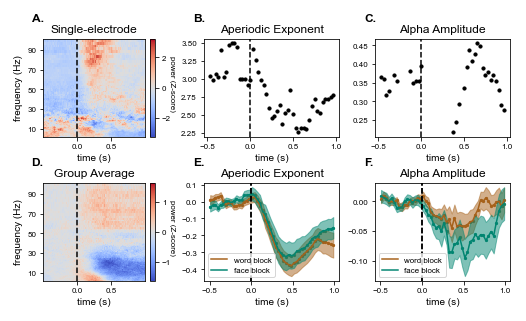

In [24]:
# Plot SpecParam time-series

# create figure
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=[WIDTH_FIG4, HEIGHT_FIG4], 
                                                      gridspec_kw={'width_ratios': [0.75, 1, 1]})

# crop time
mask = ((time_p>-0.5) & (time_p<1.0))

# ==================== Fig 4a ====================
fig, ax1 = plot_tfr(tfr_time, tfr_freq, tfr_plt, fig=fig, ax=ax1, title='Single-electrode')

# ==================== Fig 4bc ====================
# 4b - exponent
ax2.scatter(time_p[mask], exp[mask], color='k', s=10)
ax2.set_title('Aperiodic Exponent')

# 4c - alpha
ax3.scatter(time_p[mask], alpha[mask], color='k', s=10)
ax3.set_title('Alpha Amplitude')

# ==================== Fig 4d ====================
fig, ax4 = plot_tfr(time_plt_g, tfr_freq_g, tfr_plt_g, fig=fig, ax=ax4, title='Group Average')

# ==================== Fig 4de ====================
# plot time-series
ax5 = plot_time_series(ax5, exp_w, exp_f, 'Aperiodic Exponent')
ax6 = plot_time_series(ax6, alpha_w, alpha_f, 'Alpha Amplitude')

# ==================== label fig ====================
# label plots
for ax in [ax2, ax3, ax5, ax6]:
    ax.set_xlabel('time (s)')
    ax.axvline(0, color='k', linestyle='--')

# add subplot labels
fig.text(0.04, 1, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.36, 1, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.7, 1, 'C.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.04, 0.5, 'D.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.36, 0.5, 'E.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.7, 0.5, 'F.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# save
if SAVE_FIG:
    plt.savefig(join(DIR_FIG, 'fig4'),
               bbox_inches=Bbox([[0, 0],[WIDTH_FIG4, HEIGHT_FIG4+LABEL_PAD]]))


## Figure 5. Power spectra rotate about central frequencies
Spectral rotation: intersection frequency histogram

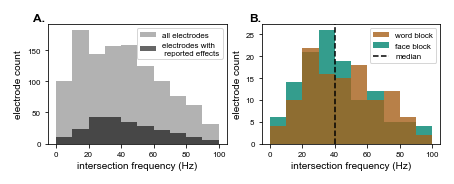

In [32]:
# plot histogram of rotation freq

# figsize
figsize_x = 6
figsize_y = 2.1

# combine data for materials
f_rot_all = np.concatenate([f_rot_face, f_rot_word])
f_rot_sig = np.concatenate([f_rot_face[sig_chans], f_rot_word[sig_chans]])

# create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[figsize_x,figsize_y])
# fig.suptitle('Intersection of Power Spectra: Baseline v. Encoding')

# ===== subplot 1 - plot =====
bin_edges = np.linspace(0,100,11)
count_allchans, _, _ = ax1.hist(f_rot_all, bins=bin_edges, alpha=0.6, color='grey', label='all electrodes')
count, _, _ = ax1.hist(f_rot_sig, bins=bin_edges, alpha=0.6, color='k', label='electrodes with\n reported effects')
ax1.legend()
# ax1.set_title('All Electrodes')

# ===== subplot 2 - plot =====
ax2.hist(f_rot_word[sig_chans], bins=bin_edges, alpha=0.8, label='word block', color=COLS_0)
ax2.hist(f_rot_face[sig_chans], bins=bin_edges, alpha=0.8, label='face block', color=COLS_1, zorder=0)
ax2.axvline(np.nanmedian(f_rot_sig), linestyle='--', color='k',label='median', zorder=2)

# subplot 2 - label, add legend
order = [0,1,2]
handles, labels = ax2.get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order]);
# ax2.set_title('Electrodes with Reported Effects')

# label both bubplots
for ax in[ax1, ax2]:
    ax.set_xlabel('intersection frequency (Hz)')
    ax.set_ylabel('electrode count')

# add subplot labels
fig.text(0.05, 1.0, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.55, 1.0, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# save fig
if SAVE_FIG:
    fig.savefig(join(DIR_FIG, 'fig5'),
               bbox_inches=Bbox([[0, 0],[figsize_x, figsize_y+LABEL_PAD]]))


In [33]:
# compute median intersection frequency - all electrodes
print('All Channels:')
print('\t median (all): %0.2f' %np.nanmedian(f_rot_all))
print('\t median (face-encoding): %0.2f' %np.nanmedian(f_rot_face))
print('\t median (word-encoding): %0.2f' %np.nanmedian(f_rot_word))

# compute median intersection frequency - significant electrodes
print('\n Signifcant Channels:')
print('\t median (all): %0.2f' %np.nanmedian(f_rot_sig))
print('\t median (face-encoding): %0.2f' %np.nanmedian(f_rot_face[sig_chans]))
print('\t median (word-encoding): %0.2f' %np.nanmedian(f_rot_word[sig_chans]))

All Channels:
	 median (all): 39.92
	 median (face-encoding): 38.92
	 median (word-encoding): 39.92

 Signifcant Channels:
	 median (all): 39.92
	 median (face-encoding): 38.42
	 median (word-encoding): 43.91


In [34]:
# find peak intersection frequency 

# find peaks - all electrodes
print('All Channels:')
print(f"\t between {bin_edges[np.argmax(count_allchans)]} and {bin_edges[np.argmax(count_allchans)+1]} Hz")

# find peaks - significant electrodes
print('\nSignifcant Channels:')
print(f"\t between {bin_edges[np.argmax(count)]} and {bin_edges[np.argmax(count)+1]} Hz")


All Channels:
	 between 10.0 and 20.0 Hz

Signifcant Channels:
	 between 20.0 and 30.0 Hz


## Figure 6. Aperiodic exponent shifts are conflated with total alpha/beta modulation.

#### set-up

In [35]:
# settings
WIDTH_FIG6 = 7
HEIGHT_FIG6 = 4 

In [36]:
# functions
def draw_regression_results(ax, x_data, results):
    # regression results
    x = np.array([np.nanmin(x_data), np.nanmax(x_data)])
    y = x * results.params[1] + results.params[0]
    
    # design text based on values
    if results.f_pvalue < .001:
        str_p = f"{results.f_pvalue:.1e}"
    else:
        str_p = f"{results.f_pvalue:.3f}"
    if results.rsquared < .001:
        str_r2 = "<0.001" #"$<e^{-3}$"
    else:
        str_r2 = f"{results.rsquared:.3f}"            
    s = "$\it{R^{2}}$: " + f"{str_r2}" + "\n$\it{p}$:   " + f"{str_p}"
        
    # plot
    ax.plot(x, y, color='k')
    ax.text(0.8,0.1, s, transform=ax.transAxes, bbox=dict(facecolor='w'), fontsize=10)

    return ax

In [37]:
# load data
data_ols = pd.read_pickle(PROJECT_PATH + 'data/results/' + 'df_ols.pkl')
data_ols.head()

,index,patient,chan_idx,label,pos_y,pos_x,pos_z,peak_present,sig,sign,diff_alpha_w,diff_alpha_f,diff_exp_w,diff_exp_f,f_rot_w,f_rot_f,diff_alpha_bp_w,diff_alpha_bp_f
0,1,pat02,1,A02-A03,-70.93895,57.17765,12.1554,3.0,NaN,NaN,0.014369,NaN,-0.218467,-0.237542,83.836257,NaN,-0.024981,-0.235090
1,2,pat02,2,A03-A04,-75.3955,51.3944,20.94335,1.0,NaN,-1.0,NaN,NaN,-0.048501,-0.124899,89.824561,57.886940,-0.134299,-0.200204
2,8,pat02,8,C03-C04,-74.67955,3.14125,33.31045,3.0,NaN,NaN,0.019199,-0.117804,0.220747,0.024264,24.951267,7.984405,0.141660,-0.070827
3,9,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,3.0,NaN,NaN,-0.177757,0.016915,-0.742720,-0.958992,36.927875,28.943470,-0.276413,-0.224495
4,38,pat04,29,A48-A56,5.42945,57.1763,38.78825,1.0,NaN,-1.0,NaN,0.007399,-0.403394,-0.409657,21.957115,62.877193,0.086706,0.046532


#### stats - linear regression

In [38]:
results = {}
for var, variable in zip(['alpha_bp', 'alpha'], ['Alpha/beta bandpower', 'adjusted Alpha/beta power']):
    for mat, material in zip(['w','f'], ['Word-encoding','Face-encoding']):
        # drop nan
        df = data_ols[[f'diff_{var}_{mat}',f'diff_exp_{mat}']]
        df = df.dropna()

        X = df[[f'diff_exp_{mat}']]
        y = df[f'diff_{var}_{mat}']

        # adding the constant 
        X = sm.add_constant(X)

        # estimating the model
        model = sm.OLS(y, X)
        results_i = model.fit()

        # aggregate
        results[f'{mat}_{var}'] = results_i
        
        # show results
        print(f"\n\n===================  {material}: {variable}  ===================\n")
        print(results_i.summary())



===================  Word-encoding: Alpha/beta bandpower  ===================

                            OLS Regression Results                            
Dep. Variable:        diff_alpha_bp_w   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     33.42
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           4.80e-08
Time:                        17:39:49   Log-Likelihood:                 105.88
No. Observations:                 139   AIC:                            -207.8
Df Residuals:                     137   BIC:                            -201.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Text(0.55, 0.48, 'D.')

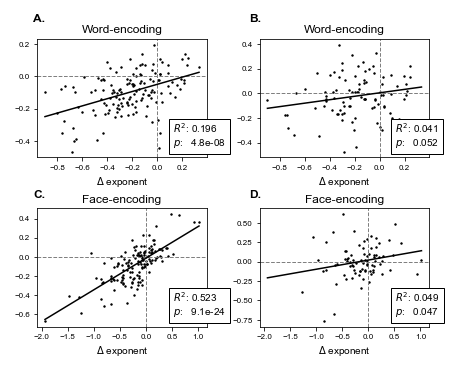

In [39]:
# plot

# create figure
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=[6, 4.7], constrained_layout=True)

# draw scatterplots
ax1.scatter(data_ols['diff_exp_w'], data_ols['diff_alpha_bp_w'], color='k', s=2)
ax2.scatter(data_ols['diff_exp_w'], data_ols['diff_alpha_w'], color='k', s=2)
ax3.scatter(data_ols['diff_exp_f'], data_ols['diff_alpha_bp_f'], color='k', s=2)
ax4.scatter(data_ols['diff_exp_f'], data_ols['diff_alpha_f'], color='k', s=2)

# label x-axes and annotate zero values
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlabel('$\Delta$ exponent')
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)

# annotate regression results and label conditions
for ax, res in zip([ax1,ax2], [results['w_alpha_bp'],results['w_alpha']]):
    ax.set_title('Word-encoding')
    ax = draw_regression_results(ax, data_ols[f'diff_exp_w'].values, res) # draw regression results 
for ax, res in zip([ax3,ax4], [results['f_alpha_bp'],results['f_alpha']]):
    ax.set_title('Face-encoding')
    ax = draw_regression_results(ax, data_ols[f'diff_exp_f'].values, res) # draw regression results

# add subplot labels
fig.text(0.05, 1.0, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.55, 1.0, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.05, 0.48, 'C.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.55, 0.48, 'D.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')


#### bootstrap regression results

In [40]:
# Bootstrap regression: drop-one subject

# init
corr = []

# loop through patients
for i_pat, patient in enumerate(PATIENTS):
    # drop a subject
    data_drop = data_ols[~(data_ols['patient']==patient)]
    
    # loop through conditions
    results_bs = {}
    for var, variable in zip(['alpha_bp', 'alpha'], ['Alpha/beta bandpower', 'adjusted Alpha/beta power']):
        for mat, material in zip(['w','f'], ['Word-encoding','Face-encoding']):    
            # drop nan
            df = data_drop[[f'diff_{var}_{mat}',f'diff_exp_{mat}']]
            df = df.dropna()

            X = df[[f'diff_exp_{mat}']]
            y = df[f'diff_{var}_{mat}']

            # adding the constant 
            X = sm.add_constant(X)

            # estimating the model
            model = sm.OLS(y, X)
            results_i = model.fit()

            # aggregate
            results_bs[f'{mat}_{var}'] = results_i

    # aggregate
    corr.append([results_bs['w_alpha_bp'].rsquared, results_bs['w_alpha'].rsquared,
                results_bs['f_alpha_bp'].rsquared, results_bs['f_alpha'].rsquared])

# reformat results as dataframe
df = pd.DataFrame()
df['variable'] = ['alpha_bp','alpha','alpha_bp','alpha'] * len(PATIENTS)
df['material'] = ['word','word','face','face'] * len(PATIENTS)
df['corr'] = np.concatenate(corr)
df.head()


,variable,material,corr
0,alpha_bp,word,0.186343
1,alpha,word,0.040297
2,alpha_bp,face,0.528485
3,alpha,face,0.050486
4,alpha_bp,word,0.180452


#### plot

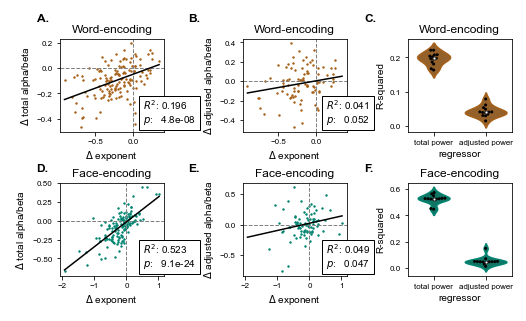

In [41]:
# plot figure 6

# create figure
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=[WIDTH_FIG6, HEIGHT_FIG6],
                                          constrained_layout=True)

# plot scatter plots (A, B, D, and E)
ax1.scatter(data_ols['diff_exp_w'], data_ols['diff_alpha_bp_w'], color=COLS_0, s=2)
ax2.scatter(data_ols['diff_exp_w'], data_ols['diff_alpha_w'], color=COLS_0, s=2)
ax4.scatter(data_ols['diff_exp_f'], data_ols['diff_alpha_bp_f'], color=COLS_1, s=2)
ax5.scatter(data_ols['diff_exp_f'], data_ols['diff_alpha_f'], color=COLS_1, s=2)

# label x-axes and annotate zero values
for ax in [ax1,ax2,ax4,ax5]:
    ax.set_xlabel('$\Delta$ exponent')
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    
# annotate regression results
for ax, res in zip([ax1,ax2], [results['w_alpha_bp'],results['w_alpha']]):
    ax = draw_regression_results(ax, data_ols[f'diff_exp_w'].values, res) # draw regression results 
for ax, res in zip([ax4,ax5], [results['f_alpha_bp'],results['f_alpha']]):
    ax = draw_regression_results(ax, data_ols[f'diff_exp_f'].values, res) # draw regression results

# label y-axis 
for ax in [ax1,ax4]:
    ax.set_ylabel('$\Delta$ total alpha/beta')
for ax in [ax2,ax5]:
    ax.set_ylabel('$\Delta$ adjusted alpha/beta')
    
# plot boxplots (C and F)
# C: word-encoding
plotting_params = {
    'data':    df[df['material']=='word'],
    'x':       'variable',
    'y':       'corr',
}
sp3 = sns.swarmplot(**plotting_params, color=[0,0,0], ax=ax3, size=3)
vp3 = sns.violinplot(**plotting_params, ax=ax3, palette={"alpha_bp": COLS_0, "alpha": COLS_0})
ax3.collections[2].set_edgecolor(COLS_0)
ax3.collections[4].set_edgecolor(COLS_0)
ax3.set(xlabel='regressor', ylabel='R-squared')
ax3.set_xticklabels(['total power','adjusted power'])

# D: face-encoding
plotting_params = {
    'data':    df[df['material']=='face'],
    'x':       'variable',
    'y':       'corr',
}
sp6 = sns.swarmplot(**plotting_params, color=[0,0,0], ax=ax6, size=3)
vp6 = sns.violinplot(**plotting_params, ax=ax6, palette={"alpha_bp": COLS_1, "alpha": COLS_1})
ax6.collections[2].set_edgecolor(COLS_1)
ax6.collections[4].set_edgecolor(COLS_1)
ax6.set(xlabel='regressor', ylabel='R-squared')
ax6.set_xticklabels(['total power','adjusted power'])

# remove mean and quartile line
for l in ax3.lines:
    l.set_linewidth(0)
for l in ax6.lines:
    l.set_linewidth(0)

# Add titles - label conditions
for ax in [ax1,ax2,ax3]:
    ax.set_title('Word-encoding')
for ax in [ax4,ax5,ax6]:
    ax.set_title('Face-encoding')

# adjust axes - share y-axis of scatterplots
# ax1.sharey(ax2)
# ax3.sharey(ax4)

# add subplot labels
fig.text(0.05, 1.0, 'A.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.35, 1.0, 'B.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.70, 1.0, 'C.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.05, 0.48, 'D.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.35, 0.48, 'E.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')
fig.text(0.70, 0.48, 'F.', fontsize=FONTSIZE_SUBPLOTS, fontweight='bold')

# save fig
if SAVE_FIG:
    fig.savefig(join(DIR_FIG, 'fig6'),
               bbox_inches=Bbox([[0, 0],[WIDTH_FIG6, HEIGHT_FIG6+LABEL_PAD]]))
